# From
http://tomaugspurger.github.io/modern-5-tidy.html

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

## Use read_html to extract a table contained within a web page

In [2]:
fp = 'nba.csv'

tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2016_games.html")
games = tables[0]
games.to_csv(fp)

games.head()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,,.1,Notes
0,"Tue, Oct 27, 2015",8:00 pm,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,NaN
1,"Tue, Oct 27, 2015",8:00 pm,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,NaN
2,"Tue, Oct 27, 2015",10:30 pm,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,NaN
3,"Wed, Oct 28, 2015",7:30 pm,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,NaN
4,"Wed, Oct 28, 2015",7:30 pm,Chicago Bulls,115,Brooklyn Nets,100,Box Score,NaN,NaN


## Clean up the table:
### Rename columns
### Transform data format
###  Set index to (game_id, date) pair

In [3]:
column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

games = (games.rename(columns=column_names)
    .dropna(thresh=4)
    [['date', 'away_team', 'away_points', 'home_team', 'home_points']]
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y'))
    .set_index('date', append=True)
    .rename_axis(["game_id", "date"])
    .sort_index())
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
1,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112
4,2015-10-28,Chicago Bulls,115,Brooklyn Nets,100


In [4]:
games.shape

(38, 4)

# games is "game oriented"
### A "game" is identified triple:
## (date, away_team, home_team) is unique key

## Wide to skinny

### Create "tidy" which is "team oriented"
#### (date, team) is unique key
### Once in this shape (skinny, rather than wide) we can easily add a "rest" column
#### Group by "team", then take within-group difference of "date" to get days between games

###   The values in the  new column "variable" are the original column names "away_team" and "home_team"; the value in the original column is stored in "team"



In [5]:
tidy = pd.melt(games.reset_index(),
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'],
               value_name='team')
tidy.head()
tidy['variable'].unique()

array(['away_team', 'home_team'], dtype=object)

In [6]:
tidy.shape

(76, 4)

In [7]:
# For each team... get number of days between games
tidy.groupby('team')['date'].diff().dt.days - 1

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
71    1.0
72    2.0
73    2.0
74    2.0
75    0.0
Name: date, dtype: float64

In [8]:
tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1
tidy.dropna().head()

,game_id,date,variable,team,rest
4,4,2015-10-28,away_team,Chicago Bulls,0.0
8,8,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,14,2015-10-28,away_team,New Orleans Pelicans,0.0
17,17,2015-10-29,away_team,Memphis Grizzlies,0.0
18,18,2015-10-29,away_team,Dallas Mavericks,0.0


## Turn back into wide table, now that we've added the "rest" column

In [9]:
by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'],
                          columns='variable')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'}))
by_game.head()

,variable,away_rest,home_rest
game_id,date,,
0,2015-10-27,NaN,NaN
1,2015-10-27,NaN,NaN
2,2015-10-27,NaN,NaN
3,2015-10-28,NaN,NaN
4,2015-10-28,0.0,NaN


In [10]:
by_game.shape

(38, 2)

## Now that by_game is wide, we can glue it to the games table
### Recall that "concat" does a join (default is outer join)
### Since both by_game and games have same number of rows, indexed by (game_id, date) the type of join doesn't matter

In [11]:
df = pd.concat([games, by_game], axis=1)
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0


# "tidy" is team oriented.
## Do some team-oriented graphing
### Plot "variable" (x) versus "rest" (y); grouped by "team" (hue)

In [12]:
tidy['variable'].unique()

array(['away_team', 'home_team'], dtype=object)

In [13]:
tidy["team"].unique().shape

(30,)

In [14]:
tidy.shape

(76, 5)

In [15]:
tidy.dropna().shape

(46, 5)

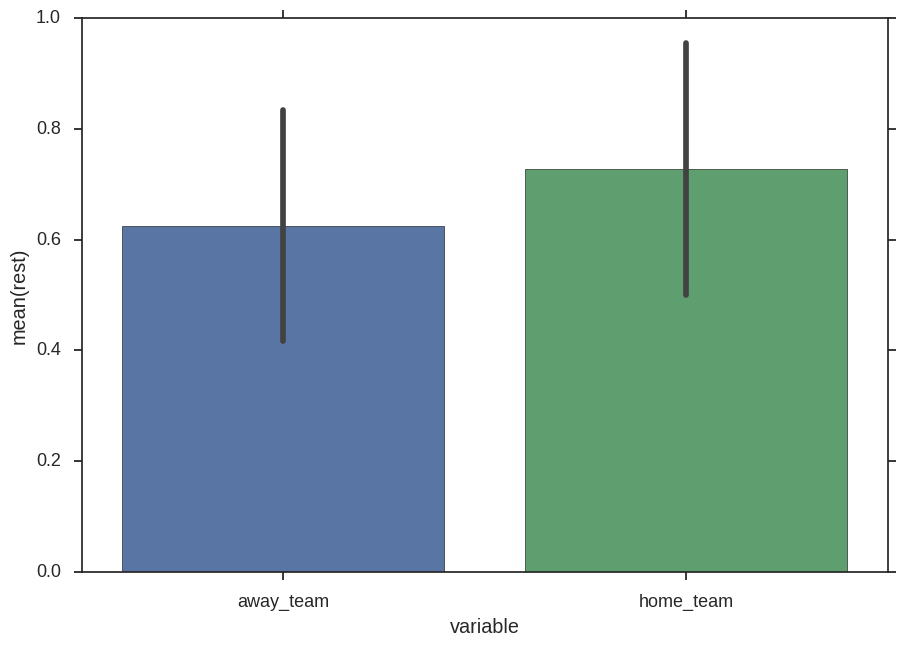

In [17]:
sns.barplot(tidy['variable'], tidy['rest'])

In [39]:
pd.Series(tidy["team"]).isin(["Detroit Pistons"])

0      True
1     False
2     False
3     False
4     False
      ...  
71    False
72    False
73    False
74    False
75    False
Name: team, dtype: bool

In [43]:
tidyOneTeam = tidy[ pd.Series(tidy['team']).isin(["Boston Celtics", "Detroit Pistons"]) ]
tidyOneTeam.sort_values('team')

,game_id,date,variable,team,rest
41,3,2015-10-28,home_team,Boston Celtics,NaN
59,21,2015-10-30,home_team,Boston Celtics,1.0
0,0,2015-10-27,away_team,Detroit Pistons,NaN
43,5,2015-10-28,home_team,Detroit Pistons,0.0
62,24,2015-10-30,home_team,Detroit Pistons,1.0


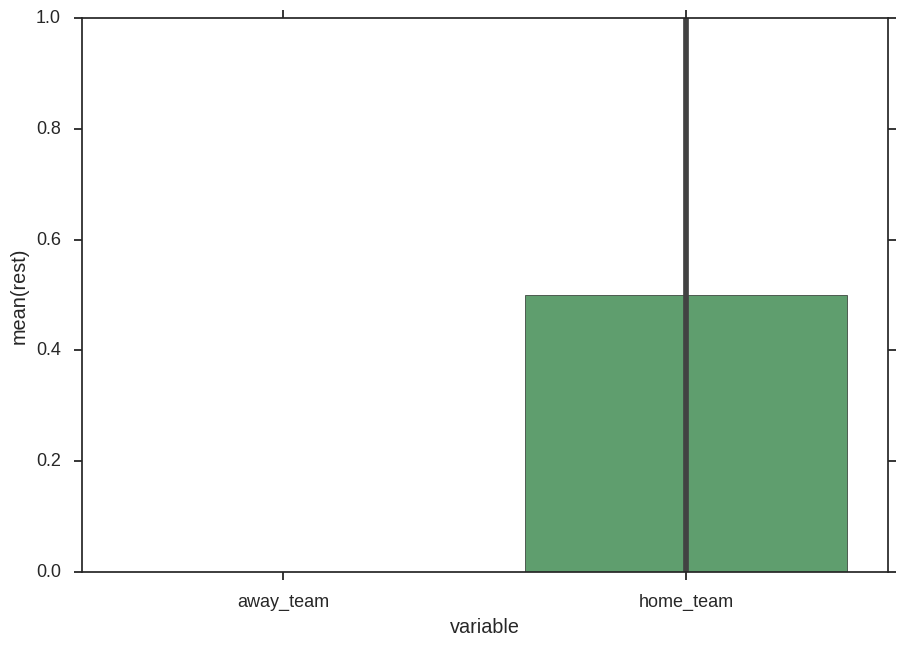

In [19]:
sns.barplot(tidyOneTeam['variable'], tidyOneTeam['rest'])

## Below doesn't look like what appears on web page, nor how
### sns.barplot works above (x-axis is "variable"): should be two bars per plot 
#### one for variable=home_team and one for variable=away_team

## Suspect problem is sns.FacetGrid
#### Get same symptom even if use tidyOneTeam as table
#### Maybe it's because most teams DON'T have BOTH home and away games

###  Note the 0 days of rest for some teams
### Also, "rest" is NaN for the first game of season since there is no prior date, but this doesn't seem to be the issue

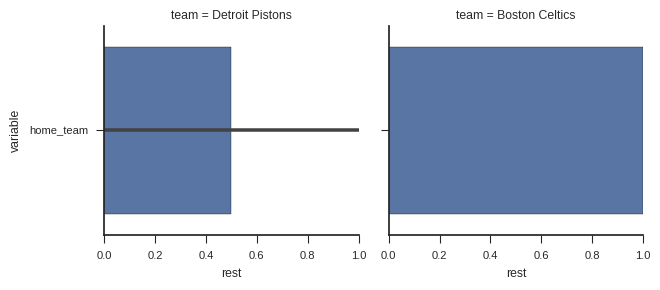

In [44]:
g = sns.FacetGrid(tidyOneTeam, col="team", col_wrap=6)
g.map(sns.barplot,  'rest', 'variable')

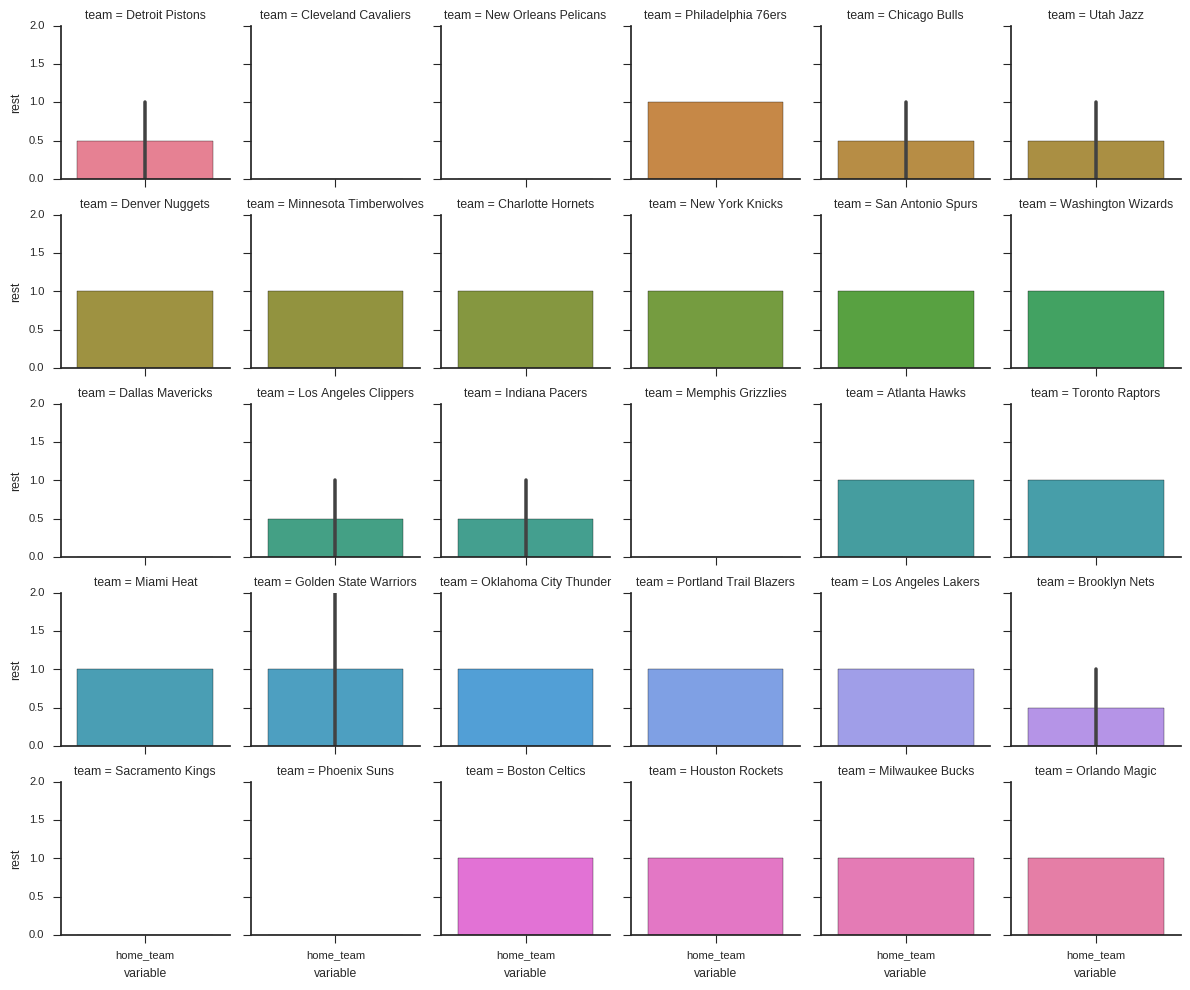

In [21]:
sns.set(style='ticks', context='paper')
g = sns.FacetGrid(tidy, col="team", col_wrap=6, hue="team", size=2)
g.map(sns.barplot, 'variable', 'rest');

In [22]:
df['home_win'] = df['home_points'] > df['away_points']
df['rest_spread'] = df['home_rest'] - df['away_rest']
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0,False,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0,True,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0,False,-1.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0,True,-1.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0,False,0.0


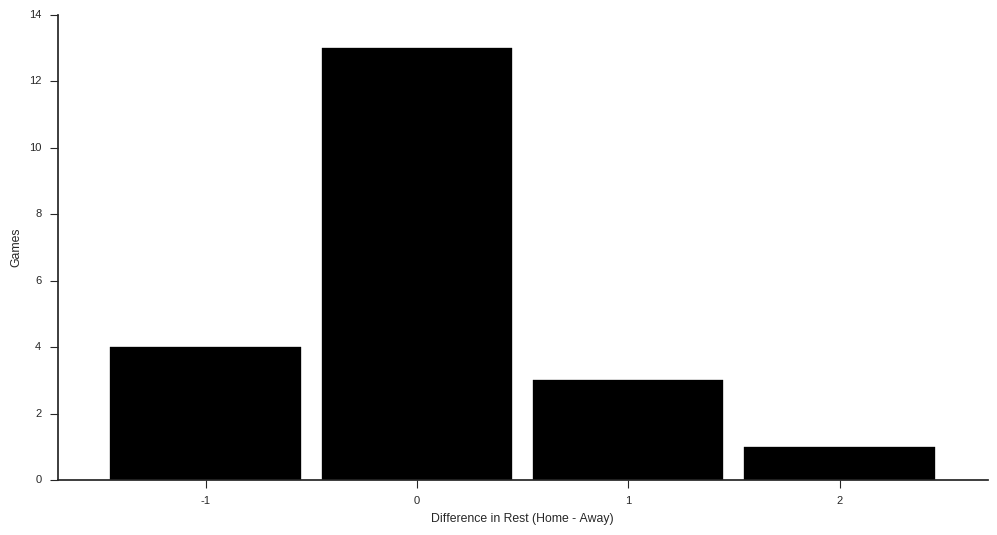

In [24]:
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)
ax = (delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6))
)
sns.despine()
ax.set(xlabel='Difference in Rest (Home - Away)', ylabel='Games')

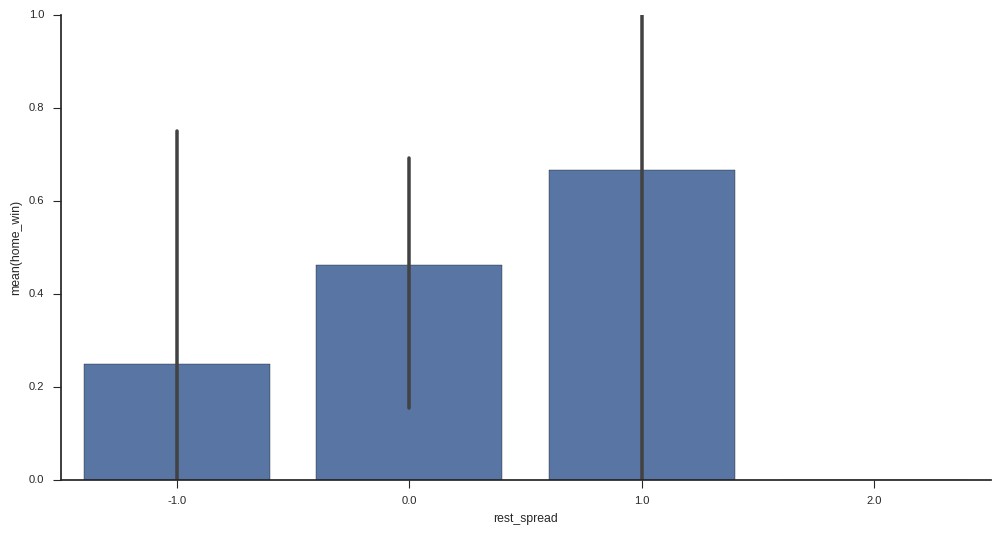

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_spread', y='home_win', data=df.query('-3 <= rest_spread <= 3'),
            color='#4c72b0', ax=ax)
sns.despine()

## Stack/Unstack (MultiIndex version of Wide to Thin, Thin to Wide)

In [26]:
rest = (tidy.groupby(['date', 'variable'])
            .rest.mean()
            .dropna())
rest.head()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
Name: rest, dtype: float64

## Thin to wide

In [28]:
rest.unstack().head()

variable,away_team,home_team
date,,
2015-10-28,0.000000,0.000000
2015-10-29,0.333333,0.000000
2015-10-30,1.083333,0.916667
2015-10-31,0.166667,0.833333


## Wide to thin

In [29]:
rest.unstack().stack()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
            home_team    0.916667
2015-10-31  away_team    0.166667
            home_team    0.833333
dtype: float64

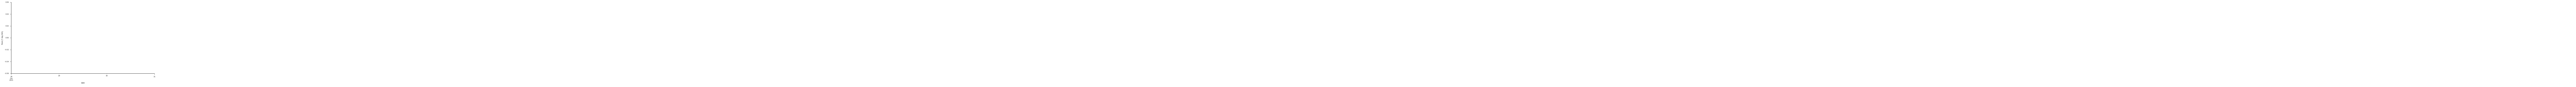

In [31]:
with sns.color_palette() as pal:
    b, g = pal.as_hex()[:2]

ax=(rest.unstack()
        .query('away_team < 7')
        .rolling(7)
        .mean()
        .plot(figsize=(12, 6), linewidth=3, legend=False))
ax.set(ylabel='Rest (7 day MA)')
ax.annotate("Home", (rest.index[-1][0], 1.02), color=g, size=14)
ax.annotate("Away", (rest.index[-1][0], 0.82), color=b, size=14)
sns.despine()